# Aptian land temperatures model-data comparison
Comapre new lignite-based land surface temperature reconstructions (brGDGT) with a suite of available model simulations to see whether absolute temperatures are in broad agreement with existing model results. Simulation differences include different models, paleogeographies and CO2 levels.

## User input

In [1]:
work_dir       = '/Users/wb19586/Documents/coding_github/early-cretaceous-lignites' # location of cloned repository
data_dir       = work_dir + '/data' # location of data files
fig_dir        = work_dir + '/figures' # location of figure files

save_figures   = True # flag whether to save figures to disk or not

## model overview
| model ID | model    | CO2 (ppm) | geography     | physics                    |
| -------- | -------- | --------- | ------------- | -------------------------- |
| KCM_600  | KCM      | 600       | Müller/Blakey | ECHAM5 default             |
| KCM_1200 | KCM      | 1200      | Müller/Blakey | ECHAM5 default             |
| teuyO    | HadCM3BL | 560       | Getech        | Valdes et al. (2017)       |
| teuyo1   | HadCM3BL | 1120      | Getech        | Valdes et al. (2017)       |
| texzx1   | HadCM3BL | 560       | Scotese       | Valdes et al. (2017)       |
| texpx2   | HadCM3BL | 1103      | Scotese       | Valdes et al. (2017)       |
| tfksx    | HadCM3BL | 780       | Scotese       | new (improved polar. amp.) |
| tfkex    | HadCM3BL | 1103      | Scotese       | new (improved polar. amp.) |

## Main code

In [2]:
# Enable the autoreload of modules
%load_ext autoreload
%autoreload 2

In [3]:
# laod packages
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd
import cartopy.crs as ccrs
import cmocean
import csv

# adjust Python path to import local modules
import sys
sys.path.append(work_dir)

from src.helper import *
from src.plotting import *
from src.reconstruction import get_scotese_paleolocation
from src.analysis import add_proxy_location_markers

### get paleolocations
Need to reconstruct paleo lat/lon for the two study sites for the three different paleogeographies:
- Müller/Blakey
- Scotese PALEOMAP
- Getech


In [4]:
# read in modern input site data
# Load the data
file_path = '/mnt/data/proxy_temps_and_locations.csv'
data_csv = pd.read_csv(f"{data_dir}/raw/proxy_temps_and_locations.csv")

# Display the first few rows of the dataframe to understand its structure
data_csv.head()

,location,modern_lat,modern_lon,maat_mean,maat_min,maat_max
0,TSG,45.2,106.2,13.4,5.4,18.3
1,SVO,46.2,108.5,8.8,5.9,15.1


In [5]:
reconstruction_age = 116 # in Ma

def getech_recon(lat, lon):
    return lat + 2.0 , lon + 14.0

def kcm_recon(lat, lon):
    return lat - 1.0, lon + 14.0

# Apply the functions to the dataset and add the columns to the CSV data
# get paleolocation from Gplates Web Service
data_csv['scotese_lat'], data_csv['scotese_lon'] = zip(*data_csv.apply(lambda row: get_scotese_paleolocation(row['modern_lat'], row['modern_lon'], reconstruction_age), axis=1))
data_csv['kcm_lat'], data_csv['kcm_lon'] = zip(*data_csv.apply(lambda row: kcm_recon(row['scotese_lat'], row['scotese_lon']), axis=1))
# data_csv['getech_lat'], data_csv['getech_lon'] = zip(*data_csv.apply(lambda row: getech_recon(row['modern_lat'], row['modern_lon']), axis=1))
# data_csv['kcm_lat'], data_csv['kcm_lon'] = zip(*data_csv.apply(lambda row: kcm_recon(row['modern_lat'], row['modern_lon']), axis=1))

# temp solution (needs to be checked)
data_csv['getech_lat'], data_csv['getech_lon'] = zip(*data_csv.apply(lambda row: getech_recon(row['scotese_lat'], row['scotese_lon']), axis=1))

# Display the modified data
data_csv.head()

,location,modern_lat,modern_lon,maat_mean,maat_min,maat_max,scotese_lat,scotese_lon,kcm_lat,kcm_lon,getech_lat,getech_lon
0,TSG,45.2,106.2,13.4,5.4,18.3,46.7,104.1,45.7,118.1,48.7,118.1
1,SVO,46.2,108.5,8.8,5.9,15.1,48.1,106.0,47.1,120.0,50.1,120.0


In [6]:
# Save the modified data to a new CSV file
output_path = f"{data_dir}/processed/proxy_temps_and_reconstructed_locations.csv"
data_csv.to_csv(output_path, index=False)

output_path

'/Users/wb19586/Documents/coding_github/early-cretaceous-lignites/data/processed/proxy_temps_and_reconstructed_locations.csv'

### paleogeographic differences
We have model simulations with three different Aptian paleogeographies (see table above). Start by plotting them side-by-side for the study region.

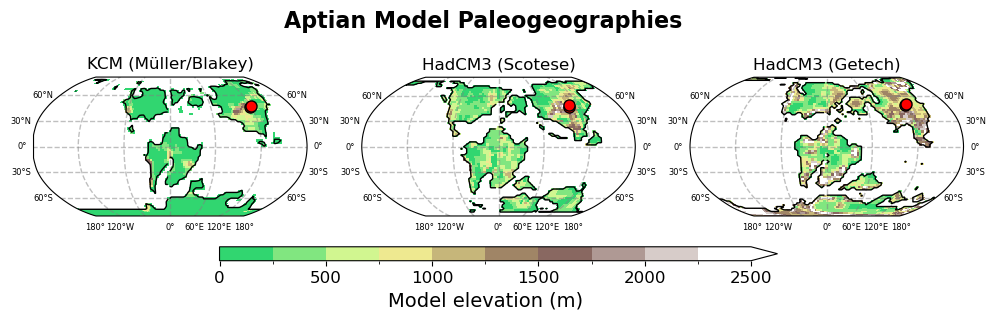

In [7]:
exp_list = ['KCM_1200', 'texzx1', 'teuyO']
exp_labels = ['KCM (Müller/Blakey)', 'HadCM3 (Scotese)', 'HadCM3 (Getech)']
orog_levels = [0,250,500,750,1000,1250,1500,1750,2000,2250,2500]

# global comparison of paleogeographies

# Load all data first
data = []
for idx,exp in enumerate(exp_list):
    # load data
    ds_orog = xr.open_dataset(f"{data_dir}/raw/model_clims/{exp}.orog.nc").squeeze()
    ds_mask = xr.open_dataset(f"{data_dir}/raw/model_clims/{exp}.mask.nc").squeeze()

    # find the variable names
    orog_name = find_varname_from_attribute(ds_orog, "unit", "m")
    mask_name = find_varname_from_keywords(ds_mask, ["land sea mask", "land/sea mask"])

    ds_orog = ds_orog.where(ds_mask[mask_name] >= 0.5, np.nan)  # Filter out bad values

    data.append((ds_orog, ds_mask, orog_name, mask_name))

# Plot the data
fig, axes = plt.subplots(1, 3, figsize=(12, 5), subplot_kw={'projection': ccrs.Robinson()})
fig.suptitle('Aptian Model Paleogeographies', fontsize=16, fontweight='bold', y = 0.7)

# use land colors only from colormap
cmap_topo = split_cmap(cmocean.cm.topo, 0.5, 1.0)

for idx, (ds_orog, ds_mask, orog_name, mask_name) in enumerate(data):
    # use land colors only from colormap
    # cmap_topo = split_cmap(cmocean.cm.topo, 0.5, 1.0)
    cmap_terrain = split_cmap(plt.cm.terrain, 0.3, 1.0)

    # global map plot with cartopy
    p = plot_filled_map(
        ax=axes[idx],
        data=ds_orog[orog_name],
        type='pcolormesh',
        cmap=cmap_terrain, 
        levels=orog_levels,
        right_labels=True,
        title=exp_labels[idx])
    
    # add coastlines
    plot_contours(ax=axes[idx], data=ds_mask[mask_name], levels=[0.8], colors=['black'], linewidths=[1])
    
    # add sitye markers
    add_proxy_location_markers(ax=axes[idx],exp=exp_list[idx], data_csv=data_csv, size=8)

# add common colorbar
cbar = fig.colorbar(p, ax=axes.ravel().tolist(), orientation='horizontal', pad=0.08, aspect=40, shrink = 0.6, extend='max')
cbar.set_label('Model elevation (m)', fontsize=14)  
cbar.ax.tick_params(labelsize=12)

#### save figure
if save_figures:
     plt.savefig(fig_dir + '/global_aptian_geographies.pdf', bbox_inches='tight')  
     
plt.show()

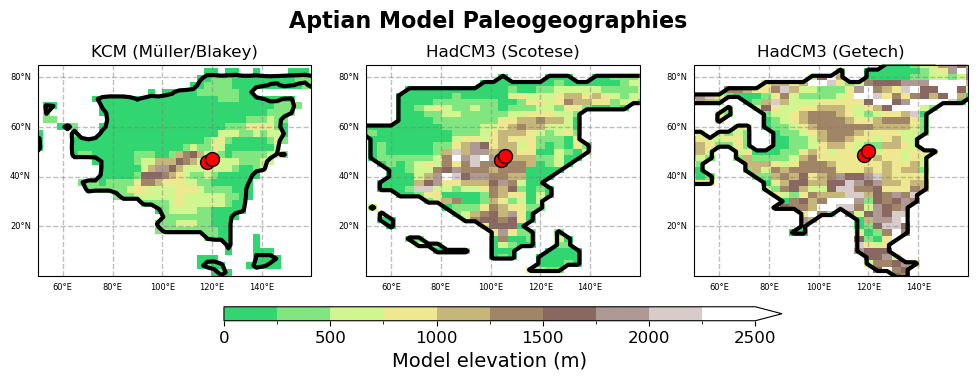

In [8]:
# plot regional comparison of paleogeographies
fig, axes = plt.subplots(1, 3, figsize=(12, 5), subplot_kw={'projection': ccrs.PlateCarree()})
fig.suptitle('Aptian Model Paleogeographies', fontsize=16, fontweight='bold', y = 0.82)

for idx, (ds_orog, ds_mask, orog_name, mask_name) in enumerate(data):
    # global map plot with cartopy
    p = plot_filled_map(
        ax=axes[idx],
        data=ds_orog[orog_name],
        type='pcolormesh',
        cmap=cmap_terrain, 
        levels=orog_levels,
        extent=[50, 160, 0, 85],
        title=exp_labels[idx])
    
    # add coastlines
    plot_contours(ax=axes[idx], data=ds_mask[mask_name], levels=[0.8], colors=['black'], linewidths=[3])
    
    # add sitye markers
    add_proxy_location_markers(ax=axes[idx],exp=exp_list[idx], data_csv=data_csv, size=10)

# add common colorbar
cbar = fig.colorbar(p, ax=axes.ravel().tolist(), orientation='horizontal', pad=0.08, aspect=40, shrink = 0.6, extend='max')
cbar.set_label('Model elevation (m)', fontsize=14)  
cbar.ax.tick_params(labelsize=12)

#### save figure
if save_figures:
     plt.savefig(fig_dir + '/regional_aptian_geographies.pdf', bbox_inches='tight')  
     
plt.show()

### regional temperature differences
maps of absolute temperatures in the study region and anomalies between simulations

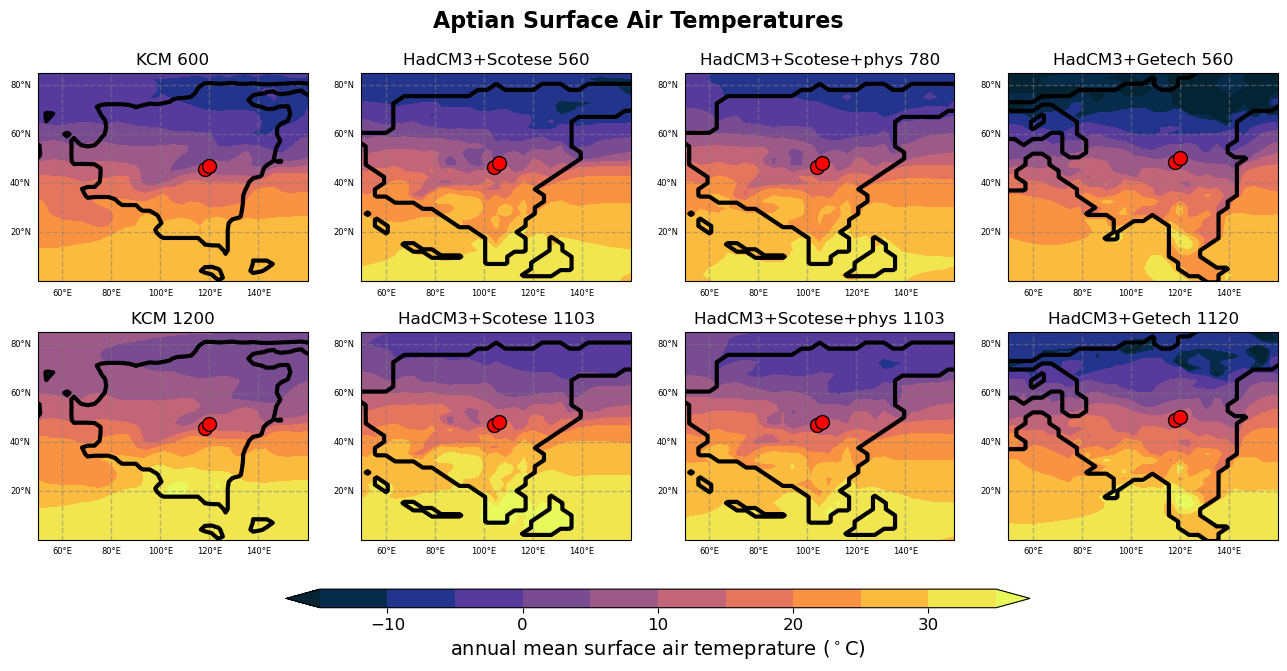

In [9]:
exp_list = ['KCM_600','KCM_1200','texzx1', 'texpx2', 'tfksx', 'tfkex', 'teuyO','teuyo1']
exp_labels = ['KCM 600','KCM 1200','HadCM3+Scotese 560', 'HadCM3+Scotese 1103', 'HadCM3+Scotese+phys 780', 'HadCM3+Scotese+phys 1103', 'HadCM3+Getech 560','HadCM3+Getech 1120']

temp_levels = np.arange(-15, 40, 5)
temp_levels_anomaly = np.arange(-10, 10, 2)

# Load all data first
data = []
for idx,exp in enumerate(exp_list):
    # load data
    ds_temp = xr.open_dataset(f"{data_dir}/raw/model_clims/{exp}.clim.nc", decode_times=False).squeeze()
    ds_mask = xr.open_dataset(f"{data_dir}/raw/model_clims/{exp}.mask.nc").squeeze()

    # find the variable names
    temp_name = find_varname_from_attribute(ds_temp, "units", "K")
    time_name = find_varname_from_attribute(ds_temp, "axis", "T")
    mask_name = find_varname_from_keywords(ds_mask, ["land sea mask", "land/sea mask"])

    ds_temp = ds_temp.mean(time_name) - 273.15
    data.append((ds_temp, ds_mask, temp_name, mask_name))

# plot regional comparison
fig, axes = plt.subplots(2, 4, figsize=(16, 8), subplot_kw={'projection': ccrs.PlateCarree()})
fig.suptitle('Aptian Surface Air Temperatures', fontsize=16, fontweight='bold', y = 0.95)

row = 0
column = 0
for idx, (ds_temp, ds_mask, temp_name, mask_name) in enumerate(data):
    # global map plot with cartopy
    p = plot_filled_map(
        ax=axes[row,column],
        data=ds_temp[temp_name],
        type='contourf',
        cmap=cmocean.cm.thermal, 
        levels=temp_levels,
        extent=[50, 160, 0, 85],
        title=exp_labels[idx])
    
    # add coastlines
    plot_contours(ax=axes[row,column], data=ds_mask[mask_name], levels=[0.8], colors=['black'], linewidths=[3])
    
    # add sitye markers
    add_proxy_location_markers(ax=axes[row,column],exp=exp_list[idx], data_csv=data_csv, size=10)

    row += 1
    if row == 2:
        row = 0
        column += 1

# add common colorbar
cbar = fig.colorbar(p, ax=axes.ravel().tolist(), orientation='horizontal', pad=0.08, aspect=40, shrink = 0.6, extend='max')
cbar.set_label('annual mean surface air temeprature ($^\circ$C)', fontsize=14)  
cbar.ax.tick_params(labelsize=12)

#### save figure
if save_figures:
     plt.savefig(fig_dir + '/regional_aptian_temperature_maps.pdf', bbox_inches='tight')  
     
plt.show()

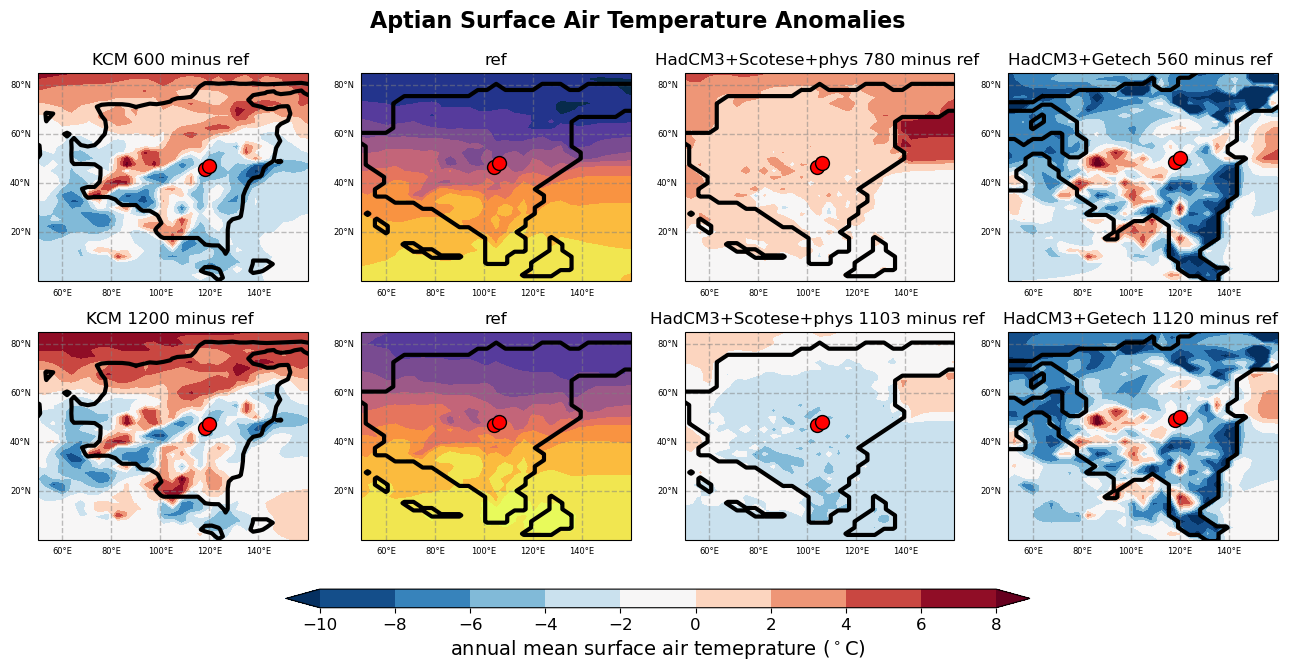

In [10]:
# plot regional comparison
fig, axes = plt.subplots(2, 4, figsize=(16, 8), subplot_kw={'projection': ccrs.PlateCarree()})
fig.suptitle('Aptian Surface Air Temperature Anomalies', fontsize=16, fontweight='bold', y = 0.95)

row = 0
column = 0
for idx, (ds_temp, ds_mask, temp_name, mask_name) in enumerate(data):

    if exp_list[idx] in ['KCM_600','tfksx','teuyO']:
        ds_temp_ref, ds_mask_ref, temp_name_ref, mask_name_ref = data[2]
        field_to_plot = ds_temp[temp_name] - ds_temp_ref[temp_name_ref]
        levels = temp_levels_anomaly
        colormap = 'RdBu_r'
        title = exp_labels[idx] + ' minus ref '
    elif exp_list[idx] in ['KCM_1200','tfkex','teuyo1']:
        ds_temp_ref, ds_mask_ref, temp_name_ref, mask_name_ref = data[3]
        field_to_plot = ds_temp[temp_name] - ds_temp_ref[temp_name_ref]
        levels = temp_levels_anomaly
        colormap = 'RdBu_r'
        title = exp_labels[idx] + ' minus ref '
    else:
        field_to_plot = ds_temp[temp_name]
        levels = temp_levels
        colormap = cmocean.cm.thermal
        title = 'ref'

    # global map plot with cartopy
    p = plot_filled_map(
        ax=axes[row,column],
        data=field_to_plot,
        type='contourf',
        cmap=colormap, 
        levels=levels,
        extent=[50, 160, 0, 85],
        title=title)
    
    # add coastlines
    plot_contours(ax=axes[row,column], data=ds_mask[mask_name], levels=[0.8], colors=['black'], linewidths=[3])
    
    # add sitye markers
    add_proxy_location_markers(ax=axes[row,column],exp=exp_list[idx], data_csv=data_csv, size=10)

    row += 1
    if row == 2:
        row = 0
        column += 1

# add common colorbar
cbar = fig.colorbar(p, ax=axes.ravel().tolist(), orientation='horizontal', pad=0.08, aspect=40, shrink = 0.6, extend='max')
cbar.set_label('annual mean surface air temeprature ($^\circ$C)', fontsize=14)  
cbar.ax.tick_params(labelsize=12)

#### save figure
if save_figures:
     plt.savefig(fig_dir + '/regional_aptian_temperature_anomaly_maps.pdf', bbox_inches='tight')  
     
plt.show()

### regional precipitation differences
repeat the maps for an overview of precipitation differences

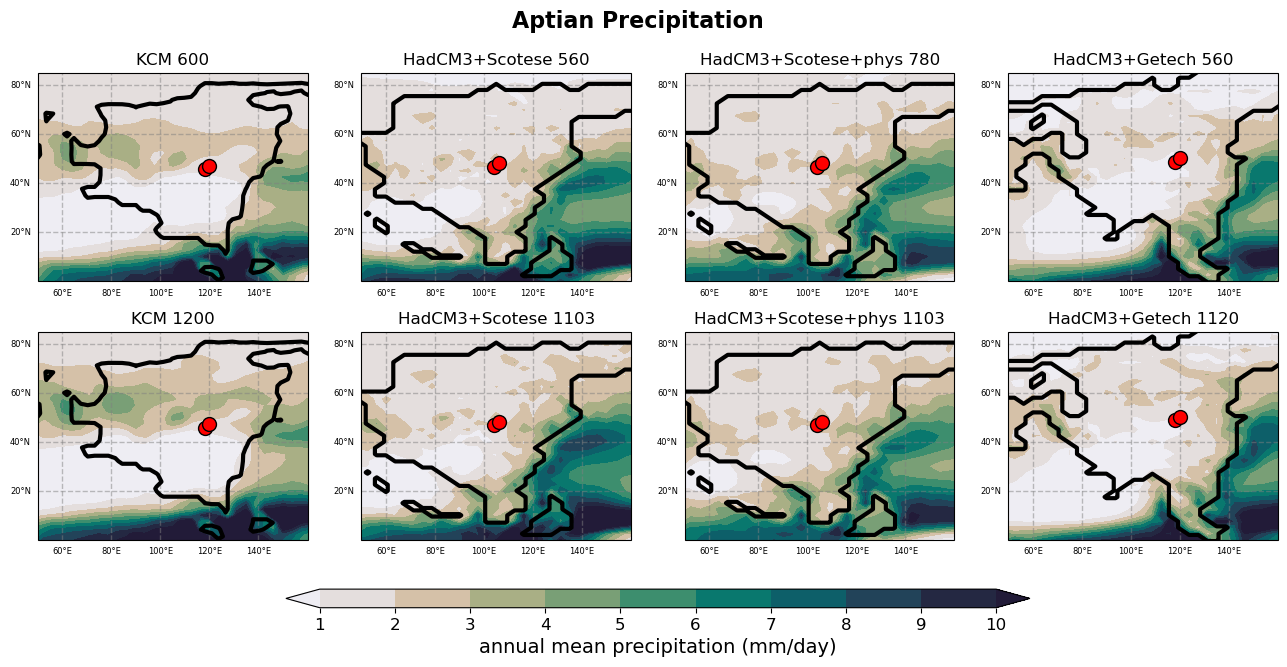

In [11]:
exp_list = ['KCM_600','KCM_1200','texzx1', 'texpx2', 'tfksx', 'tfkex', 'teuyO','teuyo1']
exp_labels = ['KCM 600','KCM 1200','HadCM3+Scotese 560', 'HadCM3+Scotese 1103', 'HadCM3+Scotese+phys 780', 'HadCM3+Scotese+phys 1103', 'HadCM3+Getech 560','HadCM3+Getech 1120']

pr_levels = np.arange(1, 11, 1)
pr_levels_anomaly = np.arange(-5, 6 , 1)

# Load all data first
data_pr = []
for idx,exp in enumerate(exp_list):
    # load data
    ds_pr = xr.open_dataset(f"{data_dir}/raw/model_clims/{exp}.clim.nc", decode_times=False).squeeze()
    ds_mask = xr.open_dataset(f"{data_dir}/raw/model_clims/{exp}.mask.nc").squeeze()

    # find the variable names
    pr_name = find_varname_from_keywords(ds_pr, ["precipitation", "PRECIPITATION"])
    time_name = find_varname_from_attribute(ds_pr, "axis", "T")
    mask_name = find_varname_from_keywords(ds_mask, ["land sea mask", "land/sea mask"])

    ds_pr = ds_pr.mean(time_name) * 86400.
    data_pr.append((ds_pr, ds_mask, pr_name, mask_name))

# plot regional comparison
fig, axes = plt.subplots(2, 4, figsize=(16, 8), subplot_kw={'projection': ccrs.PlateCarree()})
fig.suptitle('Aptian Precipitation', fontsize=16, fontweight='bold', y = 0.95)

row = 0
column = 0
for idx, (ds_pr, ds_mask, pr_name, mask_name) in enumerate(data_pr):
    # global map plot with cartopy
    p = plot_filled_map(
        ax=axes[row,column],
        data=ds_pr[pr_name],
        type='contourf',
        cmap=cmocean.cm.rain, 
        levels=pr_levels,
        extent=[50, 160, 0, 85],
        title=exp_labels[idx])
    
    # add coastlines
    plot_contours(ax=axes[row,column], data=ds_mask[mask_name], levels=[0.8], colors=['black'], linewidths=[3])
    
    # add sitye markers
    add_proxy_location_markers(ax=axes[row,column],exp=exp_list[idx], data_csv=data_csv, size=10)

    row += 1
    if row == 2:
        row = 0
        column += 1

# add common colorbar
cbar = fig.colorbar(p, ax=axes.ravel().tolist(), orientation='horizontal', pad=0.08, aspect=40, shrink = 0.6, extend='max')
cbar.set_label('annual mean precipitation (mm/day)', fontsize=14)  
cbar.ax.tick_params(labelsize=12)

#### save figure
if save_figures:
     plt.savefig(fig_dir + '/regional_aptian_precipitation_maps.pdf', bbox_inches='tight')  
     
plt.show()

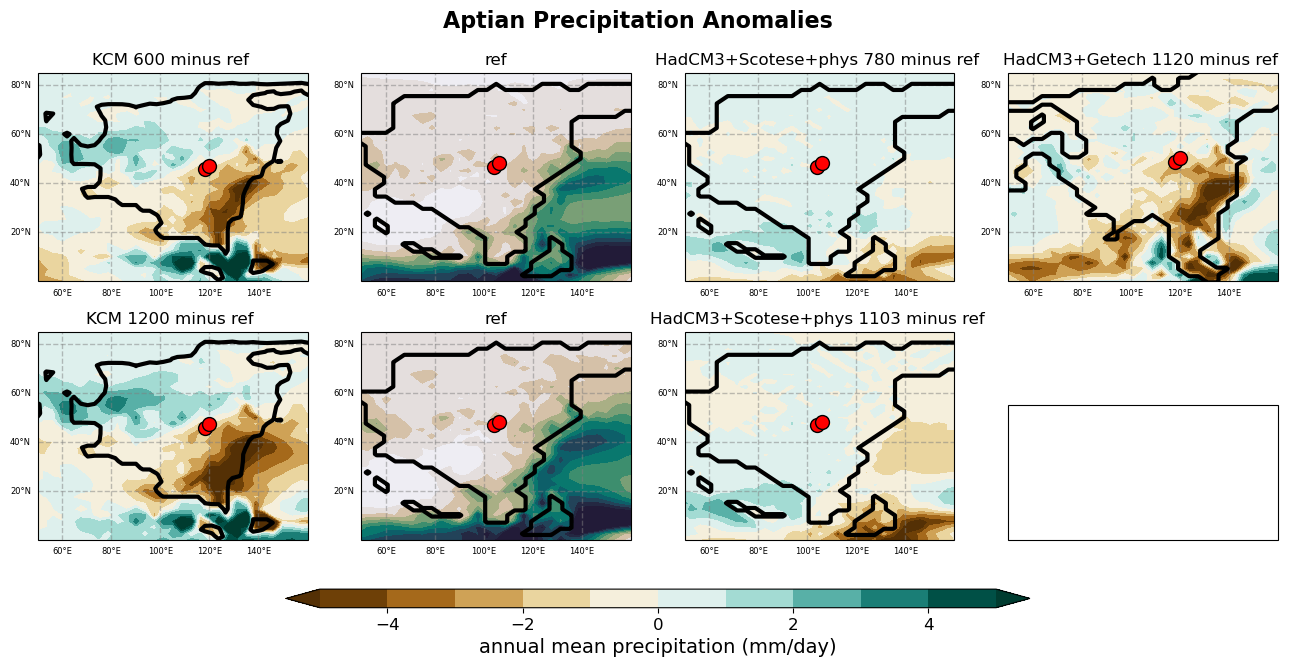

In [13]:
# plot regional differences in precipitation
fig, axes = plt.subplots(2, 4, figsize=(16, 8), subplot_kw={'projection': ccrs.PlateCarree()})
fig.suptitle('Aptian Precipitation Anomalies', fontsize=16, fontweight='bold', y = 0.95)

row = 0
column = 0
for idx, (ds_pr, ds_mask, pr_name, mask_name) in enumerate(data_pr):
    if idx == 6:
        continue
    if exp_list[idx] in ['KCM_600','tfksx','teuyO']:
        ds_pr_ref, ds_mask_ref, pr_name_ref, mask_name_ref = data_pr[2]
        if exp_list[idx] == 'teuyO':
            ds_pr[pr_name] = ds_pr[pr_name].fillna(0) -  ds_pr_ref[pr_name].fillna(0)
            field_to_plot = ds_pr[pr_name]
        else:
            field_to_plot = ds_pr[pr_name] - ds_pr_ref[pr_name_ref]
        levels = pr_levels_anomaly
        colormap = 'BrBG'
        title = exp_labels[idx] + ' minus ref '
    elif exp_list[idx] in ['KCM_1200','tfkex','teuyo1']:
        ds_pr_ref, ds_mask_ref, pr_name_ref, mask_name_ref = data_pr[3]
        field_to_plot = ds_pr[pr_name] - ds_pr_ref[pr_name_ref]
        levels = pr_levels_anomaly
        colormap = 'BrBG'
        title = exp_labels[idx] + ' minus ref '
    else:
        field_to_plot = ds_pr[pr_name]
        levels = pr_levels
        colormap = cmocean.cm.rain
        title = 'ref'

    # global map plot with cartopy
    p = plot_filled_map(
        ax=axes[row,column],
        data=field_to_plot,
        type='contourf',
        cmap=colormap, 
        levels=levels,
        extent=[50, 160, 0, 85],
        title=title)
    
    # add coastlines
    plot_contours(ax=axes[row,column], data=ds_mask[mask_name], levels=[0.8], colors=['black'], linewidths=[3])
    
    # add sitye markers
    add_proxy_location_markers(ax=axes[row,column],exp=exp_list[idx], data_csv=data_csv, size=10)

    row += 1
    if row == 2:
        row = 0
        column += 1

# add common colorbar
cbar = fig.colorbar(p, ax=axes.ravel().tolist(), orientation='horizontal', pad=0.08, aspect=40, shrink = 0.6, extend='max')
cbar.set_label('annual mean precipitation (mm/day)', fontsize=14)  
cbar.ax.tick_params(labelsize=12)

#### save figure
if save_figures:
     plt.savefig(fig_dir + '/regional_aptian_precipitation_anomaly_maps.pdf', bbox_inches='tight')  
     
plt.show()

### extract location data
extract monthly mean temperature and precipitation data for each location and model

In [14]:
exp_list = ['KCM_600','KCM_1200','texzx1', 'texpx2', 'tfksx', 'tfkex', 'teuyO','teuyo1']
exp_labels = ['KCM 600','KCM 1200','HadCM3+Scotese 560', 'HadCM3+Scotese 1103', 'HadCM3+Scotese+phys 780', 'HadCM3+Scotese+phys 1103', 'HadCM3+Getech 560','HadCM3+Getech 1120']

for idx,exp in enumerate(exp_list):
    # load data
    ds_clim = xr.open_dataset(f"{data_dir}/raw/model_clims/{exp}.clim.nc", decode_times=False).squeeze()

    # find the variable names
    temp_name = find_varname_from_attribute(ds_clim, "units", "K")
    pr_name = find_varname_from_keywords(ds_clim, ["precipitation", "PRECIPITATION"])
    time_name = find_varname_from_attribute(ds_clim, "axis", "T")

    # Find the variable name for latitude and longitude
    lon_name, lat_name = find_geo_coords(ds_clim)

    ds_clim[temp_name] -= 273.15
    ds_clim[pr_name] *= 86400.

    # get paleolocation for model
    if exp in ["KCM_600", "KCM_1200"]:
        rotation = 'kcm'
    elif exp in ["texzx1", "texpx2", "tfkex", "tfksx"]:
        rotation = 'scotese'
    elif exp in ["teuyO", "teuyo1"]:
        rotation = 'getech'
    plat = data_csv.loc[:, f'{rotation}_lat']
    plon = data_csv.loc[:, f'{rotation}_lon']

In [15]:
# Assuming earlier definitions and functions (find_varname_from_attribute, etc.) are already defined and imported.

results = []

# Loop through each experiment
for idx, exp in enumerate(exp_list):
    # Load data
    ds_clim = xr.open_dataset(f"{data_dir}/raw/model_clims/{exp}.clim.nc", decode_times=False).squeeze()
    ds_orog = xr.open_dataset(f"{data_dir}/raw/model_clims/{exp}.orog.nc", decode_times=False).squeeze()

    # Find variable names for temperature and precipitation
    temp_name = find_varname_from_attribute(ds_clim, "units", "K")
    pr_name = find_varname_from_keywords(ds_clim, ["precipitation", "PRECIPITATION"])
    orog_name = find_varname_from_attribute(ds_orog, "unit", "m")
    lon_name, lat_name = find_geo_coords(ds_clim)
    lon_name_orog, lat_name_orog = find_geo_coords(ds_orog)

    # Convert units
    ds_clim[temp_name] -= 273.15  # Kelvin to Celsius
    ds_clim[pr_name] *= 86400     # per second to mm/day

    # Get paleolocation for the model
    rotation = 'kcm' if exp in ["KCM_600", "KCM_1200"] else 'scotese' if exp in ["texzx1", "texpx2", "tfkex", "tfksx"] else 'getech'
    plat = data_csv.loc[:, f'{rotation}_lat']
    plon = data_csv.loc[:, f'{rotation}_lon']

    for idxSite, row in data_csv.iterrows():
        site_info = {
            'site': row['location'],
            'model': exp_list[idx],
            'label': exp_labels[idx],
            'plat': plat[idxSite],
            'plon': plon[idxSite],
            'pheight': ds_orog[orog_name].sel({lat_name_orog: plat[idxSite], lon_name_orog: plon[idxSite]}, method="nearest").values.round(0)
        }

        for var_name, var_label in [(temp_name, 'temperature'), (pr_name, 'precipitation')]:
            # get local values
            values = ds_clim[var_name].sel({lat_name: plat[idxSite], lon_name: plon[idxSite]}, method="nearest").values
            annual_mean = np.mean(values)
            # get zonal mean values
            values_zonal = ds_clim[var_name].sel({lat_name: plat[idxSite]}, method="nearest").values
            annual_mean_zm = np.mean(values_zonal)
            new_row = {
                **site_info,
                'variable': var_label,
                'unit': 'degC' if var_label == 'temperature' else 'mm/day',
                **{month: value for month, value in zip('Jan Feb Mar Apr May Jun Jul Aug Sep Oct Nov Dec'.split(), values)},
                'annual_mean_location': annual_mean,
                'annual_mean_zonal_mean': annual_mean_zm
            }
            results.append(new_row)

output_df = pd.DataFrame(results).round(2)
output_df.to_csv(f'{data_dir}/processed/simulated_temperature_precipitation_data_at_locations.csv', index=False)

print(output_df)

   site     model                     label  plat   plon  pheight  \
0   TSG   KCM_600                   KCM 600  45.7  118.1    528.0   
1   TSG   KCM_600                   KCM 600  45.7  118.1    528.0   
2   SVO   KCM_600                   KCM 600  47.1  120.0    556.0   
3   SVO   KCM_600                   KCM 600  47.1  120.0    556.0   
4   TSG  KCM_1200                  KCM 1200  45.7  118.1    528.0   
5   TSG  KCM_1200                  KCM 1200  45.7  118.1    528.0   
6   SVO  KCM_1200                  KCM 1200  47.1  120.0    556.0   
7   SVO  KCM_1200                  KCM 1200  47.1  120.0    556.0   
8   TSG    texzx1        HadCM3+Scotese 560  46.7  104.1   1180.0   
9   TSG    texzx1        HadCM3+Scotese 560  46.7  104.1   1180.0   
10  SVO    texzx1        HadCM3+Scotese 560  48.1  106.0   1180.0   
11  SVO    texzx1        HadCM3+Scotese 560  48.1  106.0   1180.0   
12  TSG    texpx2       HadCM3+Scotese 1103  46.7  104.1   1180.0   
13  TSG    texpx2       HadCM3+Sco

### local annual cycle
plot annual cycle of temp and precip for all mode pairs at both sites

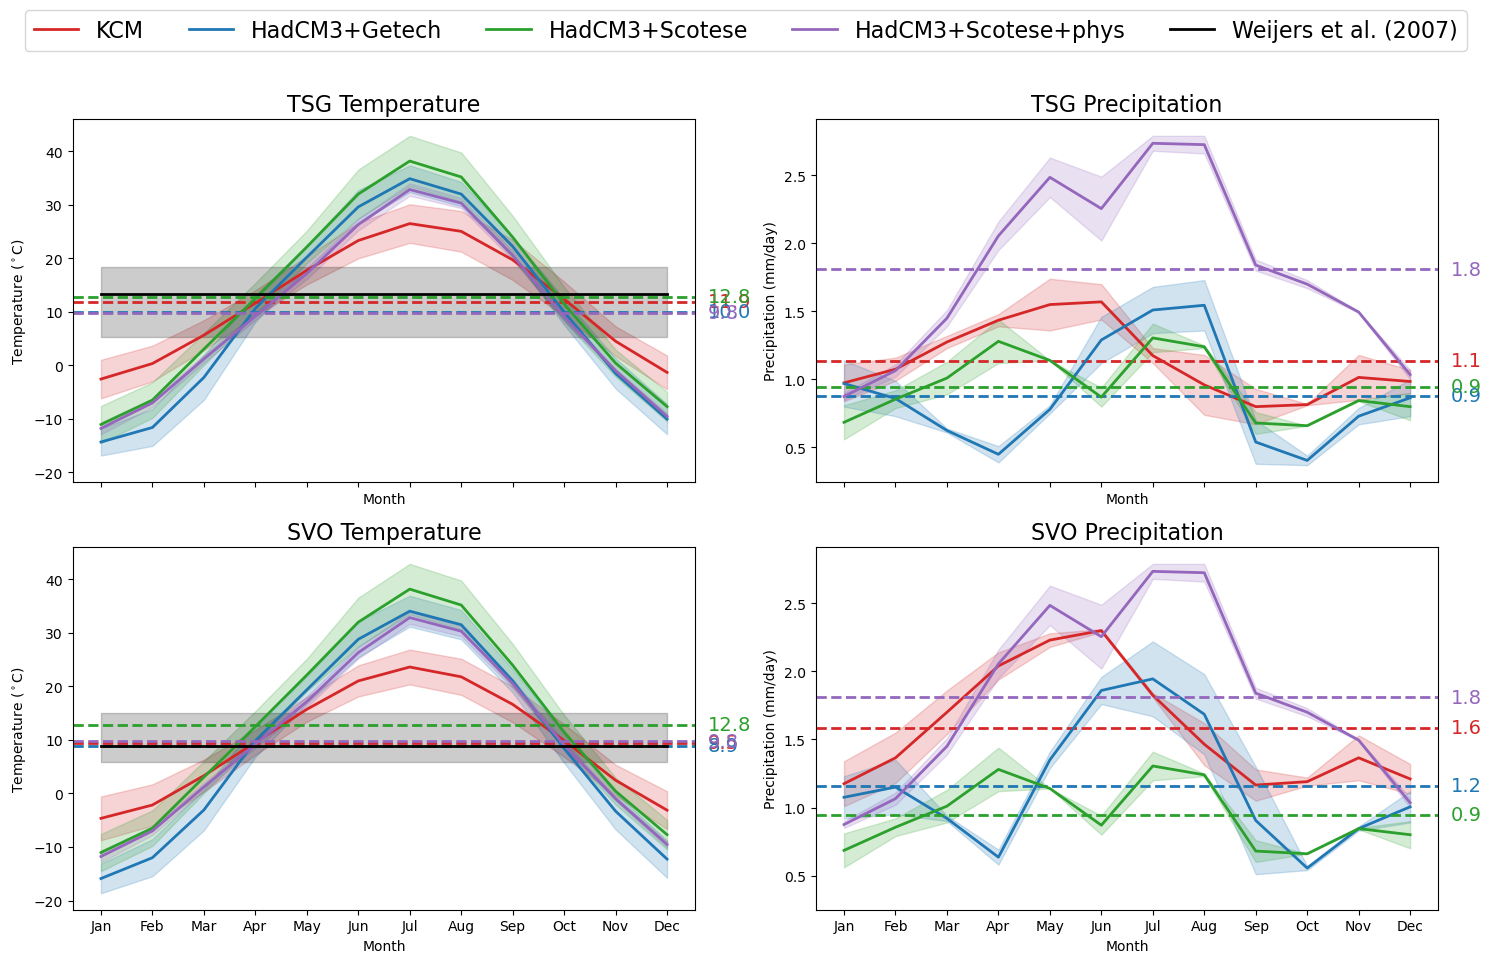

In [16]:
# Define model pairs and their corresponding colors
model_pairs = {
    'KCM': ('KCM_600', 'KCM_1200'),
    'HadCM3+Getech': ('teuyO', 'teuyo1'),
    'HadCM3+Scotese': ('texzx1', 'texpx2'),
    'HadCM3+Scotese+phys': ('tfksx', 'tfkex')
}

colors = {
    'KCM': 'tab:red',
    'HadCM3+Getech': 'tab:blue',
    'HadCM3+Scotese': 'tab:green',
    'HadCM3+Scotese+phys': 'tab:purple'
}

# Plotting
# sns.set_style("whitegrid")
fig, axs = plt.subplots(2, 2, figsize=(15, 10), sharex=True, sharey='col')
sites = ['TSG', 'SVO']
variables = ['temperature', 'precipitation']

# Helper function to plot proxy mean and range as shading
def plot_mean_and_shading(ax, site_data, variable, label, color):
    # Monthly mean
    monthly_mean = site_data.mean(axis=1)
    # Monthly range for shading
    monthly_min = site_data.min(axis=1)
    monthly_max = site_data.max(axis=1)
    # Annual mean for the dashed line
    annual_mean = site_data.mean().mean()  # Average of the monthly averages
    
    # Months
    months = monthly_mean.index.str[:3].tolist()
    
    # Plotting the mean
    ax.plot(months, monthly_mean.values, label=label, color=color, linewidth=2)
    # Shading the range
    ax.fill_between(months, monthly_min, monthly_max, color=color, alpha=0.2)
    # Horizontal dashed line for the annual mean
    ax.axhline(y=annual_mean, color=color, linestyle='--', linewidth=2)
    # Add text annotation for the annual mean
    ax.text(1.02, annual_mean, f'{annual_mean:.1f}', va='center', ha='left', color=color, transform=ax.get_yaxis_transform(), fontsize=14)

def plot_proxy_mean_and_shading(ax, proxy_data, site_data, variable, label, color):
    # Months
    months = site_data.index.str[:3].tolist()
    # Plotting the mean
    ax.plot(months, [proxy_data[1]] * 12, label=label, color=color, linewidth=2)
    # Shading the range
    ax.fill_between(months, [proxy_data[0]] * 12, [proxy_data[2]] * 12, color=color, alpha=0.2)

# Iterate through each subplot and plot the data
for i, site in enumerate(sites):
    for j, variable in enumerate(variables):
        ax = axs[i][j]
        ax.set_title(f'{site} {variable.capitalize()}', fontsize=16)

        for pair_name, (model1, model2) in model_pairs.items():
            # Filter the data for the site, variable, and model pair
            site_data = output_df[(output_df['site'] == site) & (output_df['variable'] == variable) & (output_df['model'].isin([model1, model2]))]
            # Reshape data to have models as columns and months as rows
            site_data = site_data.set_index('model').loc[:, 'Jan':'Dec'].T
            # Plot the mean and shading
            plot_mean_and_shading(ax, site_data, variable, pair_name, colors[pair_name])

        # add recosnstruction
        if site == 'TSG' and variable == 'temperature':
            plot_proxy_mean_and_shading(ax, [5.4,13.4,18.3], site_data, variable, 'Weijers et al. (2007)', 'black')
        elif site == 'SVO' and variable == 'temperature':
            plot_proxy_mean_and_shading(ax, [5.8,8.9,15.1], site_data, variable, 'Weijers et al. (2007)', 'black')

# Set common labels and legend
for i,ax in   enumerate(axs.flat):
    ax.set_xlabel('Month')
    if (i % 2) == 0:
        ax.set_ylabel('Temperature ($^\circ$C)')
    else:
        ax.set_ylabel('Precipitation (mm/day)')

# Legend
handles, labels = axs[0][0].get_legend_handles_labels()

fig.legend(handles, labels, loc='upper center', ncol=len(model_pairs)+1, fontsize=16)

plt.tight_layout(rect=[0, 0.03, 1, 0.92])

#### save figure
if save_figures:
     plt.savefig(fig_dir + '/T-P_annual_cycle.pdf', bbox_inches='tight')  
     

plt.show()

### meridional temperature gradient
put the local results in the global context

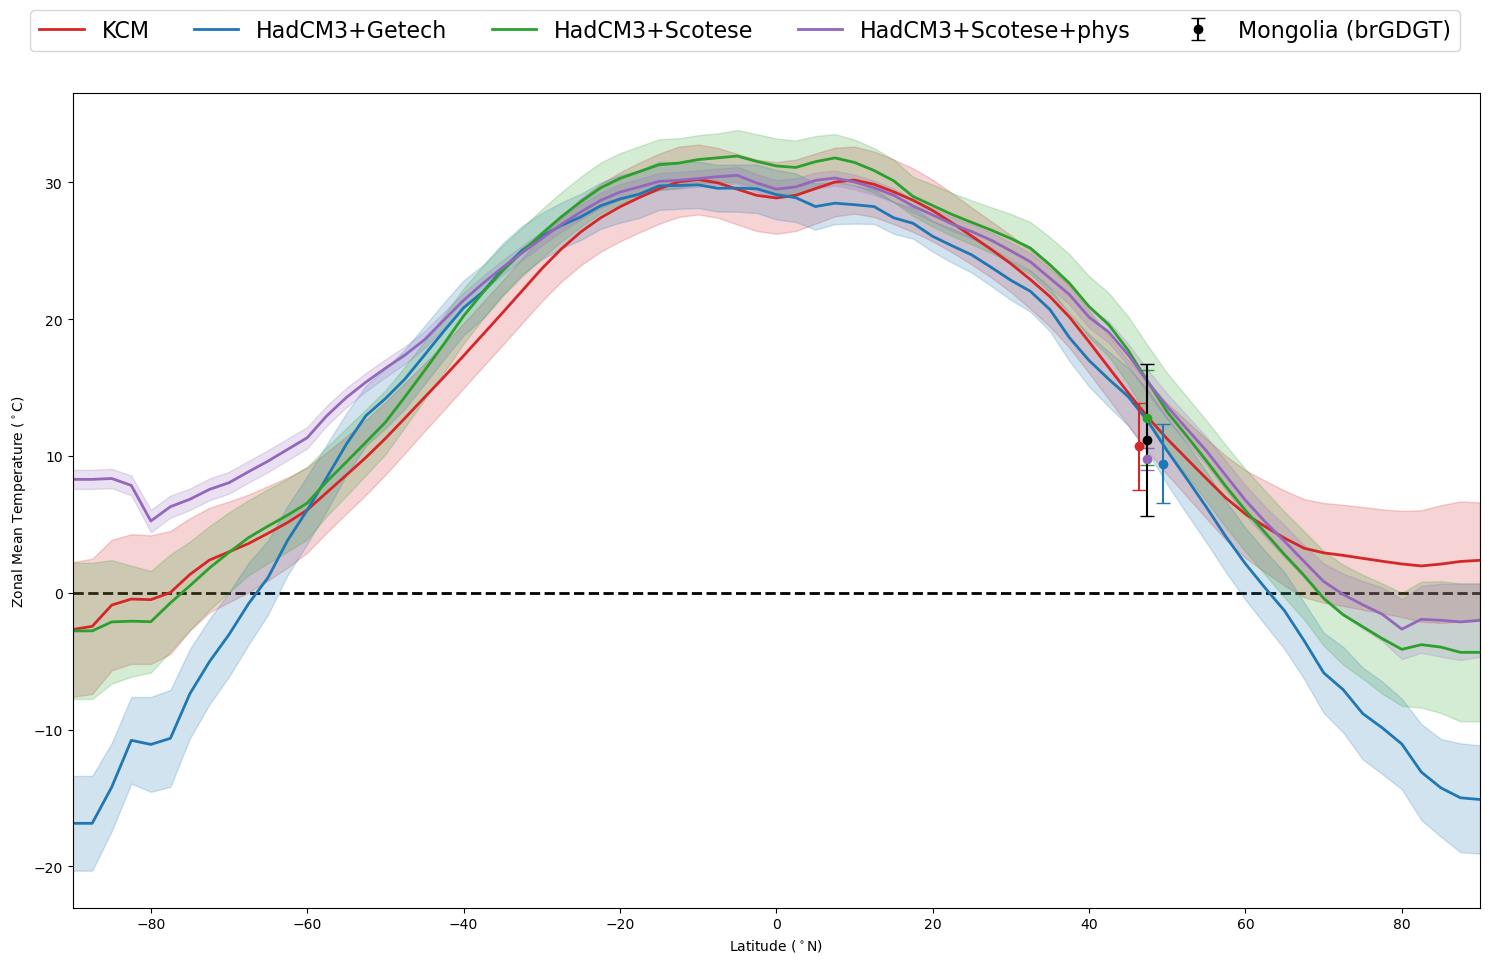

In [17]:
# Define model pairs and their corresponding colors
model_pairs = {
    'KCM': ('KCM_600', 'KCM_1200'),
    'HadCM3+Getech': ('teuyO', 'teuyo1'),
    'HadCM3+Scotese': ('texzx1', 'texpx2'),
    'HadCM3+Scotese+phys': ('tfksx', 'tfkex')
}

colors = {
    'KCM': 'tab:red',
    'HadCM3+Getech': 'tab:blue',
    'HadCM3+Scotese': 'tab:green',
    'HadCM3+Scotese+phys': 'tab:purple'
}

def plot_zonal_mean_and_shading(ax, data1, data2, lat_name, label, color):
    mean = ( data1 + data2 ) / 2
    min = xr.apply_ufunc(np.minimum, data1, data2)
    max = xr.apply_ufunc(np.maximum, data1, data2)

    # Plotting the mean
    ax.plot(data1[lat_name], mean, label=label, color=color, linewidth=2)
    # Shading the range
    ax.fill_between(data1[lat_name], min, max, color=color, alpha=0.2)
    # # Horizontal dashed line for the annual mean

fig, axs = plt.subplots(1, 1, figsize=(15, 10))

# Loop through each experiment
for idx, exp_pair in enumerate(model_pairs):
    # Load data
    ds_clim_1 = xr.open_dataset(f"{data_dir}/raw/model_clims/{model_pairs[exp_pair][0]}.clim.nc", decode_times=False).squeeze()
    ds_clim_2 = xr.open_dataset(f"{data_dir}/raw/model_clims/{model_pairs[exp_pair][1]}.clim.nc", decode_times=False).squeeze()

    # Find variable names for temperature and precipitation
    temp_name = find_varname_from_attribute(ds_clim_1, "units", "K")
    time_name = find_varname_from_attribute(ds_clim_1, "axis", "T")
    lon_name, lat_name = find_geo_coords(ds_clim_1)

    # Convert units
    ds_clim_1[temp_name] -= 273.15  # Kelvin to Celsius
    ds_clim_2[temp_name] -= 273.15  # Kelvin to Celsius

    # Get annual mean, zonal mean values
    ds_zm_1 = ds_clim_1.mean([time_name, lon_name])
    ds_zm_2 = ds_clim_2.mean([time_name, lon_name])


    plot_zonal_mean_and_shading(axs, ds_zm_1[temp_name], ds_zm_2[temp_name], lat_name, exp_pair, colors[exp_pair])

    # Get paleolocation for the model
    rotation = 'kcm' if model_pairs[exp_pair][0] in ["KCM_600", "KCM_1200"] else 'scotese' if model_pairs[exp_pair][0] in ["texzx1", "texpx2", "tfkex", "tfksx"] else 'getech'
    plat = data_csv.loc[:, f'{rotation}_lat']
    plon = data_csv.loc[:, f'{rotation}_lon']

    # average both sites
    temp_low_site_1 = ds_clim_1[temp_name].sel({lat_name: plat[0], lon_name: plon[0]}, method="nearest").mean(time_name).values
    temp_high_site_1 = ds_clim_2[temp_name].sel({lat_name: plat[0], lon_name: plon[0]}, method="nearest").mean(time_name).values
    temp_low_site_2 = ds_clim_1[temp_name].sel({lat_name: plat[1], lon_name: plon[1]}, method="nearest").mean(time_name).values
    temp_high_site_2 = ds_clim_2[temp_name].sel({lat_name: plat[1], lon_name: plon[1]}, method="nearest").mean(time_name).values

    temp_low_mean = (temp_low_site_1 + temp_low_site_2) / 2
    temp_high_mean = (temp_high_site_1 + temp_high_site_2) / 2

    model_mean = (temp_low_mean + temp_high_mean) / 2
    model_min  = np.minimum(temp_low_mean, temp_high_mean)
    model_max  = np.maximum(temp_low_mean, temp_high_mean)
    model_lower_error = model_mean - model_min
    model_upper_error = model_max - model_mean

    axs.errorbar(np.mean([plat[0],plat[1]]), model_mean, yerr=np.array([[model_lower_error], [model_upper_error]]), fmt='o', color=colors[exp_pair], capsize=5, zorder=5)

# add proxy data
# Adding a proxy estimate with error bars
proxy_mean = np.mean([13.4,8.9])
proxy_lower_error = proxy_mean - np.mean([5.4,5.9])
proxy_upper_error = np.mean([18.3,15.1]) - proxy_mean

axs.errorbar(np.mean([46.7,48.1]), proxy_mean, yerr=np.array([[proxy_lower_error], [proxy_upper_error]]), fmt='o', color='black', label='Mongolia (brGDGT)', capsize=5, zorder=5)

axs.axhline(y=0, color='black', linestyle='--', linewidth=2, zorder=0)
axs.set_xlim(min(ds_clim_1[lat_name]), max(ds_clim_1[lat_name]))
axs.set_xlabel('Latitude ($^\circ$N)')
axs.set_ylabel('Zonal Mean Temperature ($^\circ$C)')

# Legend
handles, labels = axs.get_legend_handles_labels()

fig.legend(handles, labels, loc='upper center', ncol=len(model_pairs)+1, fontsize=16)

plt.tight_layout(rect=[0, 0.03, 1, 0.92])

#### save figure
if save_figures:
     plt.savefig(fig_dir + '/meridional_temp2_gradients.pdf', bbox_inches='tight')  
     
plt.show()

### relation between local model height and difference to zonal mean values

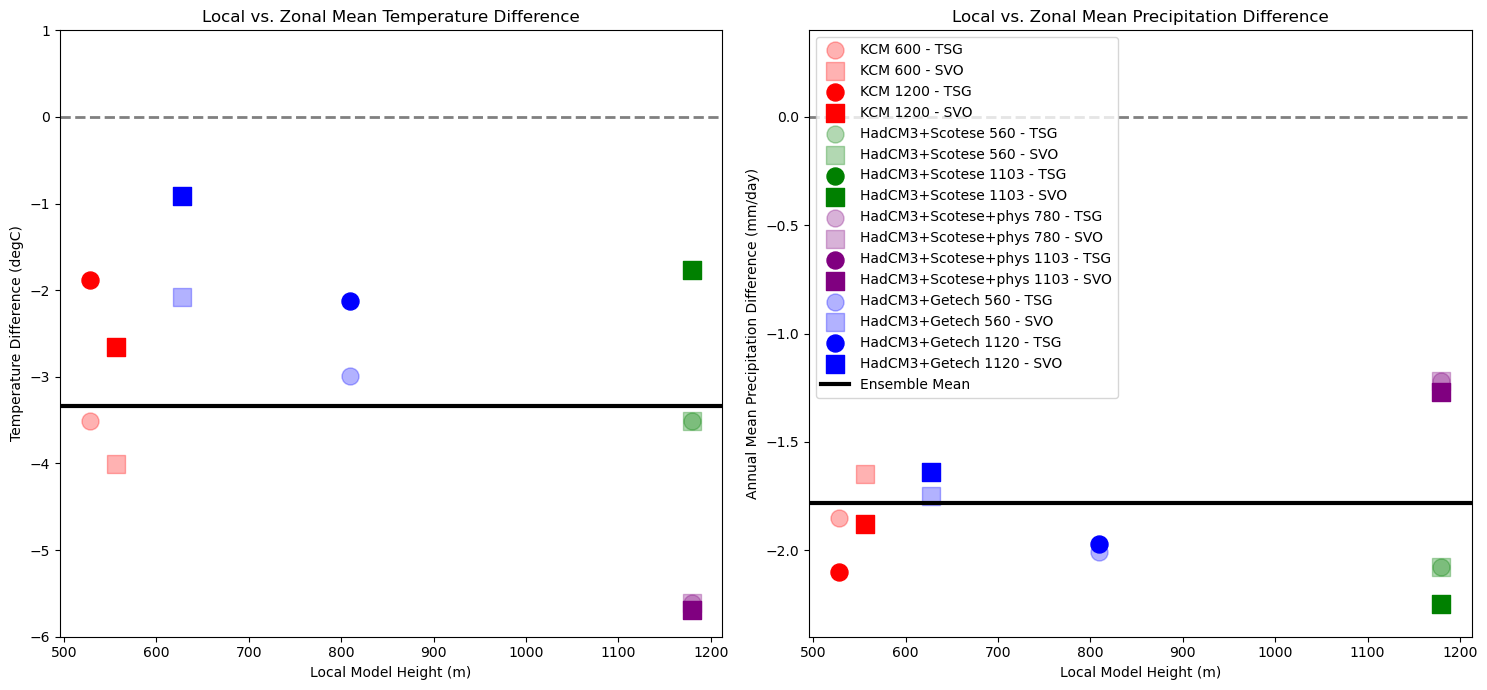

In [18]:
import pandas as pd
import matplotlib.pyplot as plt

model_pairs = {
    'KCM': ('KCM_600', 'KCM_1200'),
    'HadCM3+Getech': ('teuyO', 'teuyo1'),
    'HadCM3+Scotese': ('texzx1', 'texpx2'),
    'HadCM3+Scotese+phys': ('tfksx', 'tfkex')
}

colors = {
    'KCM': 'red',
    'HadCM3+Getech': 'blue',
    'HadCM3+Scotese': 'green',
    'HadCM3+Scotese+phys': 'purple'
}

# Load the CSV file into a DataFrame
input_csv = pd.read_csv(f'{data_dir}/processed/simulated_temperature_precipitation_data_at_locations.csv')

# Define the list of experiments/models of interest
exp_list = ['KCM_600', 'KCM_1200', 'texzx1', 'texpx2', 'tfksx', 'tfkex', 'teuyO', 'teuyo1']
colors = ['red', 'red','green', 'green', 'purple', 'purple', 'blue', 'blue']
exp_labels = ['KCM 600','KCM 1200','HadCM3+Scotese 560', 'HadCM3+Scotese 1103', 'HadCM3+Scotese+phys 780', 'HadCM3+Scotese+phys 1103', 'HadCM3+Getech 560','HadCM3+Getech 1120']

# Filter the DataFrame for the models of interest
filtered_df = input_csv[input_csv['model'].isin(exp_list)]

# Prepare to plot, defining the subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 7))

# Loop through each unique model in the filtered DataFrame
for idx,model in enumerate(exp_list):
    if model in ['KCM_600', 'texzx1', 'tfksx', 'teuyO']:
        alpha = 0.3
    else:
        alpha = 1.0
    # Separate the data by temperature and precipitation for the current model
    model_data_temp = filtered_df[(filtered_df['model'] == model) & (filtered_df['variable'] == 'temperature')]
    model_data_prec = filtered_df[(filtered_df['model'] == model) & (filtered_df['variable'] == 'precipitation')]

    # Site TSG - Temperature
    axs[0].scatter(model_data_temp[model_data_temp['site'] == 'TSG']['pheight'],
                   model_data_temp[model_data_temp['site'] == 'TSG']['annual_mean_location'] -
                   model_data_temp[model_data_temp['site'] == 'TSG']['annual_mean_zonal_mean'],
                   label=f'{exp_labels[idx]} - TSG', marker='o', color=colors[idx], s=150, alpha=alpha)
    
    # Site SVO - Temperature
    axs[0].scatter(model_data_temp[model_data_temp['site'] == 'SVO']['pheight'],
                   model_data_temp[model_data_temp['site'] == 'SVO']['annual_mean_location'] -
                   model_data_temp[model_data_temp['site'] == 'SVO']['annual_mean_zonal_mean'],
                   label=f'{exp_labels[idx]} - SVO', marker='s', color=colors[idx], s=150, alpha=alpha)
    
    # Site TSG - Precipitation
    axs[1].scatter(model_data_prec[model_data_prec['site'] == 'TSG']['pheight'],
                   model_data_prec[model_data_prec['site'] == 'TSG']['annual_mean_location'] -
                   model_data_prec[model_data_prec['site'] == 'TSG']['annual_mean_zonal_mean'],
                   label=f'{exp_labels[idx]} - TSG', marker='o', color=colors[idx], s=150, alpha=alpha)
    
    # Site SVO - Precipitation
    axs[1].scatter(model_data_prec[model_data_prec['site'] == 'SVO']['pheight'],
                   model_data_prec[model_data_prec['site'] == 'SVO']['annual_mean_location'] -
                   model_data_prec[model_data_prec['site'] == 'SVO']['annual_mean_zonal_mean'],
                   label=f'{exp_labels[idx]} - SVO', marker='s', color=colors[idx], s=150, alpha=alpha)

# Compute average y-values for temperature and precipitation differences
average_temp_diff = filtered_df[(filtered_df['variable'] == 'temperature')]['annual_mean_location'] - \
                    filtered_df[(filtered_df['variable'] == 'temperature')]['annual_mean_zonal_mean']
average_prec_diff = filtered_df[(filtered_df['variable'] == 'precipitation')]['annual_mean_location'] - \
                    filtered_df[(filtered_df['variable'] == 'precipitation')]['annual_mean_zonal_mean']

mean_temp_diff = average_temp_diff.mean()
mean_prec_diff = average_prec_diff.mean()

axs[0].axhline(y=mean_temp_diff, color='black', linestyle='-', linewidth=3, label='Ensemble Mean')  # Add horizontal line
axs[1].axhline(y=mean_prec_diff, color='black', linestyle='-', linewidth=3, label='Ensemble Mean')  # Add horizontal line

axs[0].axhline(y=0, color='gray', linestyle='--', linewidth=2)  # Add horizontal line
axs[1].axhline(y=0, color='gray', linestyle='--', linewidth=2)  # Add horizontal line

# Set the titles and labels
axs[0].set_title('Local vs. Zonal Mean Temperature Difference')
axs[0].set_xlabel('Local Model Height (m)')
axs[0].set_ylabel('Temperature Difference (degC)')

axs[1].set_title('Local vs. Zonal Mean Precipitation Difference')
axs[1].set_xlabel('Local Model Height (m)')
axs[1].set_ylabel('Annual Mean Precipitation Difference (mm/day)')

# Add legends
axs[1].legend()

axs[0].set_ylim(-6, 1)
axs[1].set_ylim(-2.4, 0.4)

# Show the plot
plt.tight_layout()

#### save figure
if save_figures:
     plt.savefig(fig_dir + '/diff_to_zonal_mean.pdf', bbox_inches='tight')  
     
plt.show()